In [1]:
%pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models, Module
from torchsummary import summary
from torchview import draw_graph

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

import time
import copy
import cv2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Given train & test sets
g_train = {"fake": [], "real": []}
g_test  = {"fake": [], "real": []}

# Base directories
base_dirs = [
    "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001",
    "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001"
]

# Labels
labels = ["fake", "real"]

# Read the images
for base_dir in base_dirs:
    for label in labels:
        # Construct the image directory path
        img_dir = os.path.join(base_dir, "train" if "train" in base_dir else "test", label)
        
        # List all files in the directory and construct full paths
        files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        
        # Append files to the appropriate dictionary
        if "train" in base_dir:
            g_train[label] += files
        else:
            g_test[label] += files
print("Done!")

Done!


In [5]:
# merge all images and labels accordingly
all_images = []
all_labels = []
for label in labels:
    all_images += g_train[label] + g_test[label]
    all_labels += [label]*len(g_train[label]) + [label]*len(g_test[label])

print("Done!")

Done!


In [6]:
# display the tabels
data = pd.DataFrame({"images": all_images, "labels":all_labels})
display(data)

,images,labels
0,/kaggle/input/deepfake-image-detection/train-2...,fake
1,/kaggle/input/deepfake-image-detection/train-2...,fake
2,/kaggle/input/deepfake-image-detection/train-2...,fake
3,/kaggle/input/deepfake-image-detection/train-2...,fake
4,/kaggle/input/deepfake-image-detection/train-2...,fake
...,...,...
973,/kaggle/input/deepfake-image-detection/test-20...,real
974,/kaggle/input/deepfake-image-detection/test-20...,real
975,/kaggle/input/deepfake-image-detection/test-20...,real
976,/kaggle/input/deepfake-image-detection/test-20...,real


In [7]:
# for betetr randomization, shuffles the data
data = data.sample(frac=1, random_state=42)  # Shuffle in place
data.reset_index(drop=True, inplace=True)  # Reset index in place

# Display the shuffled DataFrame
display(data)

,images,labels
0,/kaggle/input/deepfake-image-detection/test-20...,fake
1,/kaggle/input/deepfake-image-detection/train-2...,real
2,/kaggle/input/deepfake-image-detection/test-20...,fake
3,/kaggle/input/deepfake-image-detection/test-20...,real
4,/kaggle/input/deepfake-image-detection/train-2...,fake
...,...,...
973,/kaggle/input/deepfake-image-detection/train-2...,fake
974,/kaggle/input/deepfake-image-detection/test-20...,fake
975,/kaggle/input/deepfake-image-detection/train-2...,real
976,/kaggle/input/deepfake-image-detection/test-20...,fake


In [8]:
# convert the labels into numeric formate
label_map = {'fake': 0, 'real':1}
# apply into the table
data['labels'] = data['labels'].map(label_map)
# Display the updated DataFrame
display(data)

,images,labels
0,/kaggle/input/deepfake-image-detection/test-20...,0
1,/kaggle/input/deepfake-image-detection/train-2...,1
2,/kaggle/input/deepfake-image-detection/test-20...,0
3,/kaggle/input/deepfake-image-detection/test-20...,1
4,/kaggle/input/deepfake-image-detection/train-2...,0
...,...,...
973,/kaggle/input/deepfake-image-detection/train-2...,0
974,/kaggle/input/deepfake-image-detection/test-20...,0
975,/kaggle/input/deepfake-image-detection/train-2...,1
976,/kaggle/input/deepfake-image-detection/test-20...,0


In [9]:
Images = []
Labels = []
# height and weidth
max_height = float('-inf')
min_height = float('inf')
max_weidth = float('-inf')
min_weidth = float('inf')
for i in range(len(data)):
    image_path = data['images'][i]
    label = data['labels'][i]
    try:
        # read images 
        img = cv2.imread(image_path)
        # convert BGR  to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
           raise FileNotFoundError("Image not found or unable to read the file.")
        Images.append(img)
        Labels.append(label)
        max_height = max(max_height, img.shape[0])
        min_height = min(min_height, img.shape[0])
        max_weidth = max(max_weidth, img.shape[1])
        min_weidth  = min(min_weidth, img.shape[1])
    except Exception as e:
        print("An unexpected error occurred:", e)

print(f"Max Height: {max_height}")
print(f"Min Height: {min_height}")

print(f"Max Weidth: {max_weidth}")
print(f"Min Weidth: {min_weidth}")

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Max Height: 7091
Min Height: 135
Max Weidth: 8495
Min Weidth: 183


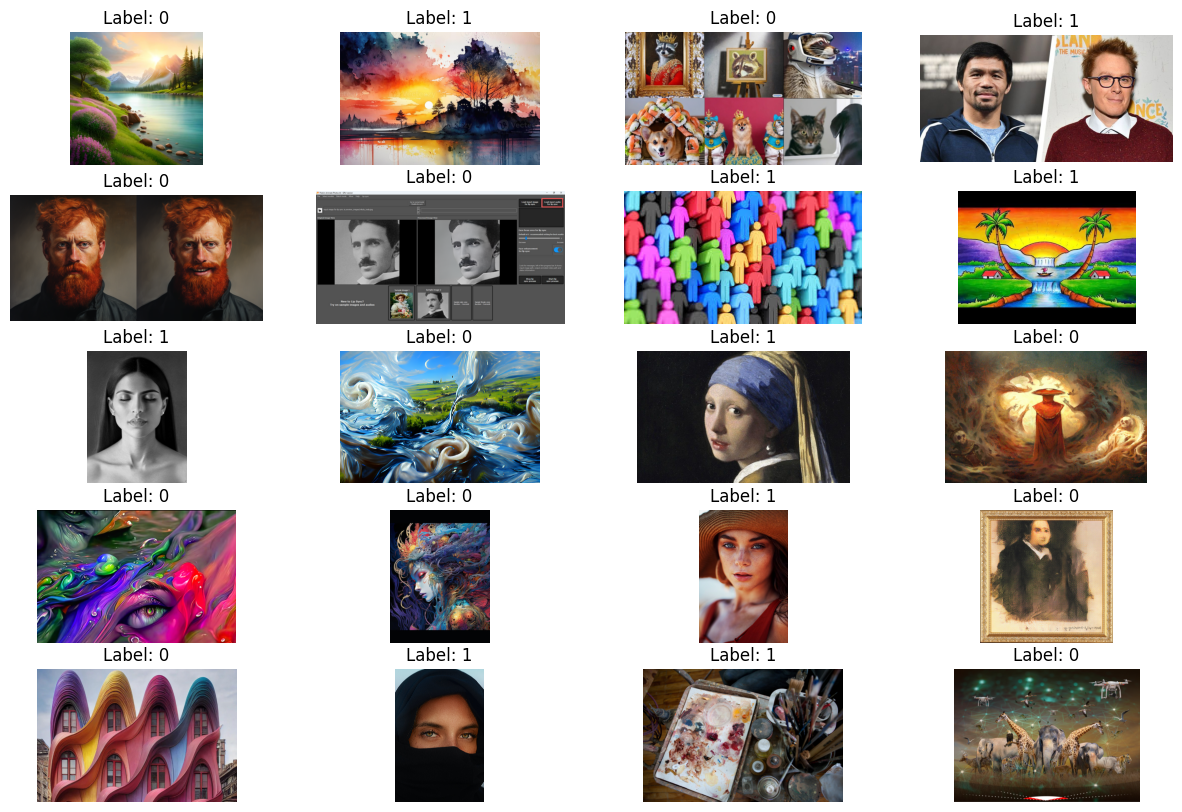

In [10]:
# Visualize some images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

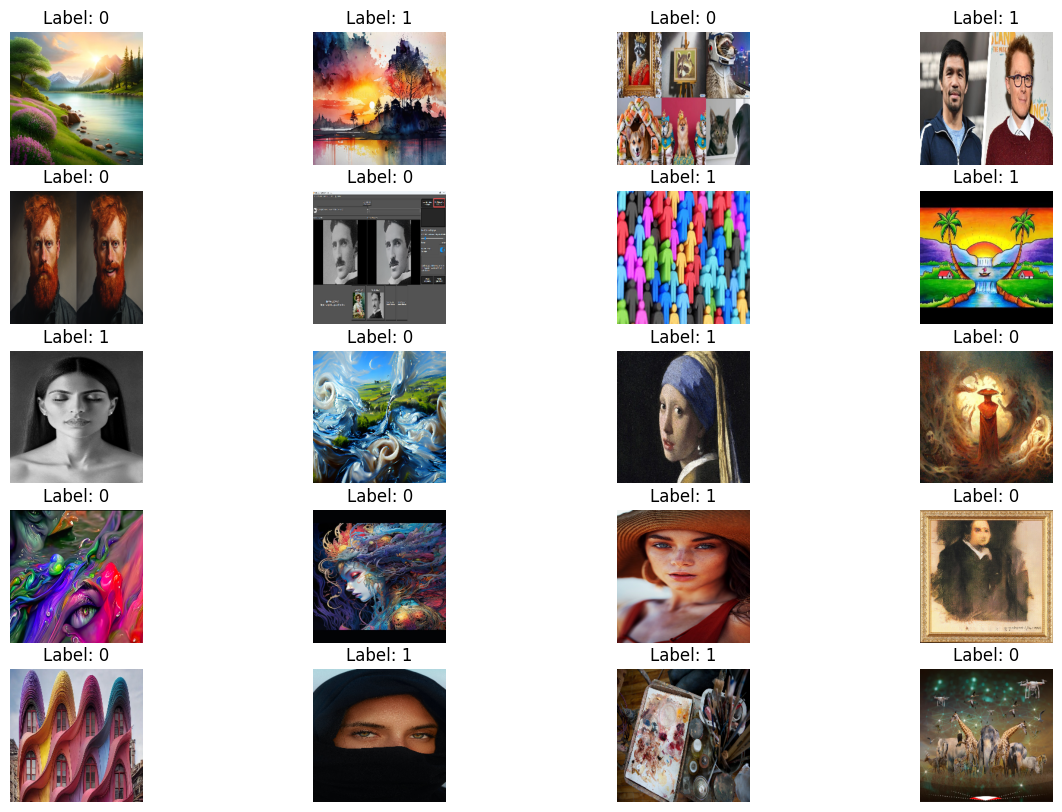

In [11]:
# resize the images
target_size = (224,224)
Images_resize = [cv2.resize(img, target_size) for img in Images]

# Visualize some images
# number of images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images_resize[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    Images_resize, 
    Labels, 
    test_size=0.05, 
    random_state=42, 
    stratify=Labels  
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.05, 
    random_state=42, 
    stratify=y_train_val 
)

print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")

Train: 882, Val: 47, Test: 49


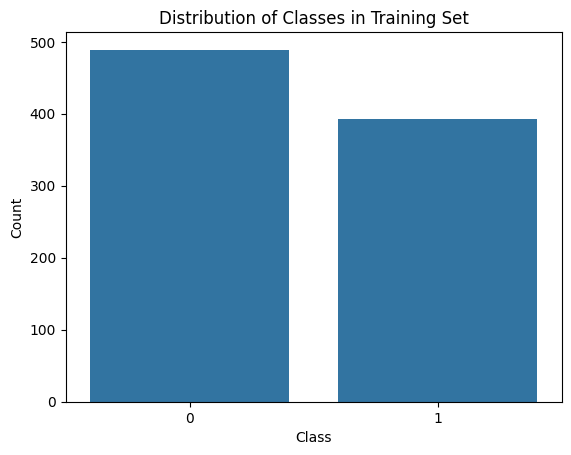

In [13]:
# Create a count plot
sns.countplot(x=np.array(y_train))

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Set")

# Show the plot
plt.show()

In [14]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV (NumPy) image to PIL format
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to Tensor [0,1], normalized pixel
])

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: List of NumPy arrays (H, W, C) 
        labels: List or NumPy array of shape (N,)
        transform: Augmentation transformations
        """
        self.images = np.array(images)  # Keep as NumPy array, apply transforms later
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        self.transform = transform  # Store the transform function

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)  # Apply augmentations

        label = self.labels[idx]
        return image, label

# Create dataset and DataLoader
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [15]:
# Fetch one batch
images, labels = next(iter(train_dataloader))
print(images.shape)  # Expected: [batch_size, 3, H, W]
print(labels)

torch.Size([64, 3, 224, 224])
tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1])


In [16]:
def get_model():
    # Load pre-trained EfficientNet_B0
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    num_ftrs = model.classifier[1].in_features
    
    # Replace the last Linear layer
    model.classifier[1] = nn.Linear(num_ftrs, 2) 
    
    return model.to(device)

model = get_model()
print("✅ Model loaded and modified for Binary Classification.")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 223MB/s]


✅ Model loaded and modified for Binary Classification.


In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [18]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam is usually best for Transfer Learning)
# Use a low learning rate (0.0001) to avoid destroying pre-trained weights
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
# Adjust epochs based on your patience (5-10 is usually enough for a demo)
trained_model, history = train_model(
    model, 
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    num_epochs=20 #20
)

Epoch 1/20
----------
train Loss: 0.6750 Acc: 0.5805
val Loss: 0.6213 Acc: 0.7660

Epoch 2/20
----------
train Loss: 0.5403 Acc: 0.7800
val Loss: 0.4926 Acc: 0.8298

Epoch 3/20
----------
train Loss: 0.4294 Acc: 0.8469
val Loss: 0.4583 Acc: 0.8085

Epoch 4/20
----------
train Loss: 0.3341 Acc: 0.8957
val Loss: 0.3803 Acc: 0.8511

Epoch 5/20
----------
train Loss: 0.2627 Acc: 0.9218
val Loss: 0.3477 Acc: 0.8511

Epoch 6/20
----------
train Loss: 0.1970 Acc: 0.9467
val Loss: 0.3625 Acc: 0.8723

Epoch 7/20
----------
train Loss: 0.1451 Acc: 0.9671
val Loss: 0.3968 Acc: 0.8085

Epoch 8/20
----------
train Loss: 0.1102 Acc: 0.9785
val Loss: 0.3566 Acc: 0.8723

Epoch 9/20
----------
train Loss: 0.0892 Acc: 0.9819
val Loss: 0.3364 Acc: 0.8723

Epoch 10/20
----------
train Loss: 0.0671 Acc: 0.9819
val Loss: 0.4712 Acc: 0.8723

Epoch 11/20
----------
train Loss: 0.0505 Acc: 0.9898
val Loss: 0.3227 Acc: 0.8723

Epoch 12/20
----------
train Loss: 0.0423 Acc: 0.9943
val Loss: 0.4490 Acc: 0.8723

E

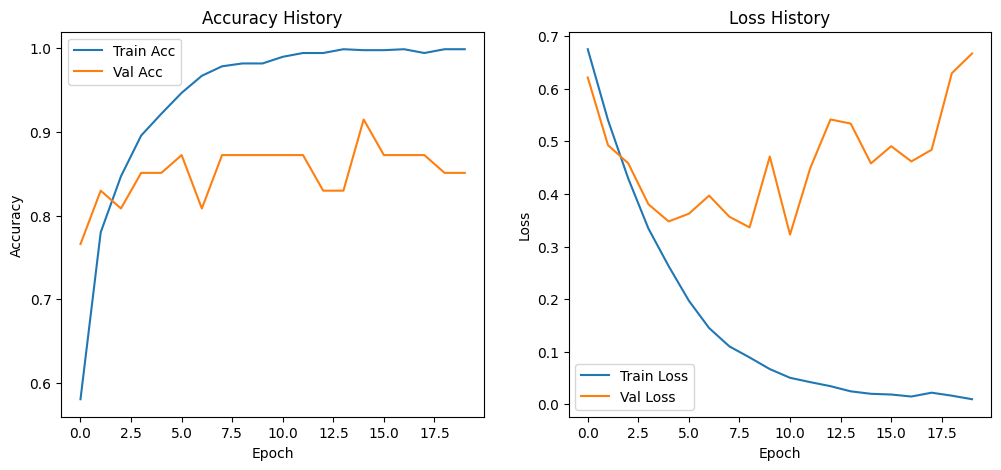

In [19]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.96      0.93      0.94        27
    Real (1)       0.91      0.95      0.93        22

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49



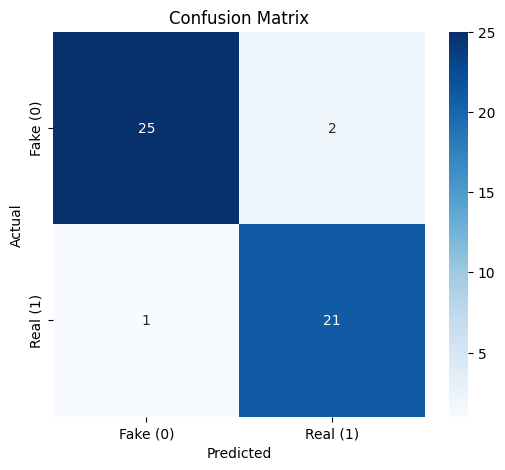

In [20]:
# 1. Create Test DataLoader (using the list X_test you created earlier)
# Note: transform should usually be just ToTensor for testing (no rotation/flip)
# But since your transform includes ToTensor, we can reuse it or define a simpler one.

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

test_dataset = CustomImageDataset(X_test, y_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Evaluation Function
def evaluate_model(model, dataloader):
    model.eval() # Set to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

# 3. Get Predictions
print("Evaluating on Test Set...")
y_true, y_pred = evaluate_model(trained_model, test_dataloader)

# 4. Classification Report
target_names = ['Fake (0)', 'Real (1)']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()